# Nutrition Calculator  - Australian Food Composition Database

#### Mission Statement
The goal of this project is to analyze commonly consumed foods and gain a deep understanding of their nutrition content. We are often told to eat a balanced diet and get most of our vitamins and minerals from food sources when possible. However, rarely does anyone track these micronutrients. I want to gain an understanding of how easy it is to satisfy the recommended requirements and understand which foods make this easier. By finding the most nutrient dense foods, foods that have the rarest nutrients, and what foods together complete our daily requirements, I hope to build a complete lifestyle diet for myself.

The Australian Food Composition Database is a well made and well documented free online database which provides data on a lot of typical foods that people eat all over the world. 

#### Data sources
nutrition data: https://www.foodstandards.gov.au/science-data/monitoringnutrients/afcd 
<br> recommended intake data: https://www.myfooddata.com/articles/recommended-daily-intakes.php

#### Techniques used:
- Pandas for data cleaning and aggregation
- Matplotlib and Seaborn for visualization
- Iterative imputation method for data imputation using scikit-learn
- Principle Component Analysis (PCA)
- Data standardization (for PCA)
- K-means clustering using scikit-learn

#### Flowplan


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tabulate import tabulate
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
sns.set()
%matplotlib inline

In [2]:
# Import food and nutrition data #

food = pd.read_excel('Australian_Food_Composition_Database/Food Details.xlsx') 
nutrient = pd.read_excel('Australian_Food_Composition_Database/Nutrient file.xlsx',
                         sheet_name='All solids & liquids per 100g')

## Need to drop percent fatty acid content, not necessary for calculation and data cleaning causes repition ##
nutrient = nutrient.drop(columns = ['Total polyunsaturated fatty acids, equated (%T)', 
                          'Total long chain omega 3 fatty acids, equated \n(%T)'])
## Import Daily Value (DV) ##

dv = pd.read_csv('daily value.csv', index_col=0)
dv.head()

,RDI,DV,UL
Nutrient,,,
Calories,2000,2000,NaN
Fat,NaN,78g,NaN
Saturated Fat,NaN,20g,NaN
Cholesterol,NaN,300mg,NaN
Carbs,130g,275g,NaN


In [3]:
## Need to drop percent content columns. Not relevant to goal and causing duplicate columns later on ##
print("Number of columns in df before drop:", len(nutrient.columns))

percent_pattern = r'\(%\w+\)'
percent_cols = nutrient.columns.str.contains(percent_pattern)
print("Number of columns with % in header:", percent_cols.sum())
nutrient = nutrient.drop(columns = nutrient.columns[percent_cols])
print("Number of columns after dropping %:", len(nutrient.columns))

gN_pattern = r'\/gN'
gN_cols = nutrient.columns.str.contains(gN_pattern)
print("Number of columns with /gN in header:", gN_cols.sum())
nutrient = nutrient.drop(columns = nutrient.columns[gN_cols])
print("Number of columns after dropping /gN:", len(nutrient.columns))

Number of columns in df before drop: 291
Number of columns with % in header: 69
Number of columns after dropping %: 222
Number of columns with /gN in header: 18
Number of columns after dropping /gN: 204


## Data Cleaning

In [4]:
# Get rid of \n's from headers #
col_pattern = r'\s?\n\(.+\)'
nutr_cols = nutrient.columns.str.replace(col_pattern, '', regex=True)
new_cols = dict(zip(nutrient.columns, nutr_cols))
nutrient_clean = nutrient.rename(columns=new_cols)

# Change energy to calories #

fiber=True #toggle this to change how calories from fiber are calculated

if fiber==True:
    energy_cols = {'Energy with dietary fibre, equated': 'Calories'}
    nutrient_clean = nutrient_clean.rename(columns=energy_cols)
    nutrient_clean = nutrient_clean.drop(columns='Energy, without dietary fibre, equated')

else:
    energy_cols = {'Energy, without dietary fibre, equated': 'Calories'}
    nutrient_clean = nutrient_clean.rename(columns=energy_cols)
    nutrient_clean = nutrient_clean.drop(columns='Energy with dietary fibre, equated')

## Convert kJ to kCal ## 
nutrient_clean['Calories'] = nutrient_clean['Calories'].apply(lambda x: x/4.2)  #multiply kJ by this to get kcal

In [5]:
# Extract Units From Cols#

### Attempt 1 - Deleting###
"""The main plan is to delete units in table header. Because every unit in both datasets are metric, an inconsistency 
in units would manifest as a 3 orders of magnitude off which will be investigated in further analysis."""

# Get rid of (abbrev.)#
col_pattern = r' \(.+\)'
nutr_cols = nutrient_clean.columns.str.replace(col_pattern, '',regex=True)
new_cols = dict(zip(nutrient_clean.columns, nutr_cols))
nutrient_clean = nutrient_clean.rename(columns=new_cols)


In [6]:
# Need to change column names to be equivalent between food and DV #

## Vitamins ##
vitamins = {'Thiamin': 'Vitamin B1',
'Riboflavin': 'Vitamin B2',
'Niacin derived equivalents': 'Vitamin B3', 
'Pantothenic acid':'Vitamin B5',
'Pyridoxine':'Vitamin B6',
'Biotin': 'Vitamin B7',
'Total folates': 'Vitamin B9',
'Cobalamin': 'Vitamin B12',
'Vitamin A retinol equivalents':'Vitamin A',
'Vitamin D3 equivalents': 'Vitamin D'
           }
nutrient_clean = nutrient_clean.rename(columns=vitamins)

## Fat ##
nutrient_clean = nutrient_clean.rename(columns = {'Fat, total': 'Fat', 
                                                    'Total saturated fatty acids, equated': 'Saturated Fat',
                                                   'Total long chain omega 3 fatty acids, equated': 'Omega 3s'
                                                   })

### Adding omega 6s from manual Calc ###
### Assuming any polyunsaturated fat that isn't omega-3 is an omega-6
nutrient_clean['Omega 6s'] = round(nutrient_clean['Total polyunsaturated fatty acids, equated'] - nutrient_clean['Omega 3s']*0.001,2)
nutrient_clean['Omega 3s'] *= 0.001
## Carbohydrates ##
carbs = {'Total sugars':'Sugar',
          'Total dietary fibre':'Fiber',
        'Available carbohydrate, with sugar alcohols':'Carbs'}
nutrient_clean = nutrient_clean.rename(columns=carbs)

## Misc Nutrients ##

misc_nutr = {'Cystine plus cysteine':'Cystine',
            }
nutrient_clean = nutrient_clean.rename(columns=misc_nutr)


#### Investigating NaN's

In [7]:
# Look at nutrient NaNs and determine whether or not they represent 0's

## Using leucine as an example 
leucine = nutrient_clean['Leucine']
print('Number of foods with null leucine values:', leucine.isnull().sum(),
      '\nNumber of foods with non-null:', leucine.notnull().sum())

notnull_leucine = nutrient_clean[leucine.notnull()]
null_leucine = nutrient_clean[leucine.isnull()]

"""The vast majority of foods are missing amino acid data. It would require combining an entire dataset which would
involve matching food names accurately, which is outside of the scope of this project. Either food with missing data 
must be excluded, or we must exclude these nutrients from the fitting criteria. In order to preserve the most data
possible, I an doing to drop the nutrients instead of the foods. For similar reasons as listed below, amino acids
are subcategories of protein, which is included in the data set. I do believe the fitting of these nutrients, like
many others being excluded, to be important and should be subject of an expansion to this study."""

# Make NaNs in food data 0 #
# nutrient_values_only = nutrient_values_only.fillna(0)


## Find columns with mostly NaN's and drop

mostly_empty = []

for cols in nutrient_clean:
    if nutrient_clean[cols].isnull().sum() > nutrient_clean[cols].notnull().sum():
        mostly_empty.append(cols)
        
nutrient_clean = nutrient_clean.drop(columns=mostly_empty)

Number of foods with null leucine values: 1435 
Number of foods with non-null: 181


In [8]:
# Dropping carb types #

"""In a similar vein, carbohydrates are non-essential nutrients (meaning there are no essential carbohydrates), so the
carbohydrate composition is not important information. However, it is best to have complex carbohydrates instead of 
simple ones like fructose and starches. For now, the total carbohydrates and total sugar will behave as a good proxy
measurement. Furthermore, having too many carbohydrate fitting variables, and too few protein and fat, could bias the
output. For these reasons, all but these columns will be dropped. Including these nutrients with fat and amino acid 
compositions would serve as a valuable expansion of this model."""

carb_cols = ['Starch', 'Sucrose', 'Glucose', 'Fructose', 'Lactose', 'Maltose']
dv = dv.drop(index=carb_cols)
nutrient_clean = nutrient_clean.drop(columns=carb_cols)

## Drop ash column, not a relevant nutrient ##
nutrient_clean = nutrient_clean.drop(columns='Ash')

In [9]:
def shared_columns(df1, df2):
    
    """Finds which columns in df1 are and are not shared with df2"""
    
    df1_cols = df1.columns
    df2_cols = df2.columns
    
    shared_cols = []
    diff_cols = []
    
    for cols in df1_cols:
        if cols in df2_cols:
            shared_cols.append(cols)
        else:
            diff_cols.append(cols)
    
    return shared_cols, diff_cols

In [10]:
## Find DV columns that aren't equal to nutrient cols ##

dv_clean = dv.rename(index={'Lutein+zeazanthin': 'Lutein'})
nutr_cols = nutrient_clean.columns
dv_shared = shared_columns(dv_clean.transpose(), nutrient_clean)


"""This data does not exist in the food list df, therefore we will ignore these nutrients. Water is a 
nutrient that should be satisfied outside of food consumption. Therefore, it should be excluded
from the analysis. Furthermore, the remaining incongruent sets are non-essential amino acids which can
be produced in the human body, making it less important for consumption. Vitamin K and Choline
are essential in the human diet. However, the food data set does not have these included. This data could 
be imputed in the event of expanding the model for a more robust study."""

dv_clean = dv_clean.drop(index=dv_shared[1])
print("Dropping columns:", dv_shared[1])
dv_shared_dropped = shared_columns(dv_clean.transpose(), nutrient_clean)

print("Shared columns:", len(dv_shared_dropped[0]),"\nDifferent columns:", len(dv_shared_dropped[1]))



Dropping columns: ['Vitamin K', 'Choline', 'Lycopene', 'Lutein', 'Ash', 'Water', 'Galactose', 'Histidine', 'Threonine', 'Isoleucine', 'Lysine', 'Leucine', 'Methionine', 'Cystine', 'Phenylalanine', 'Tyrosine', 'Valine', 'Arginine', 'Alanine', 'Aspartic Acid', 'Glutamic Acid', 'Glycine', 'Proline', 'Serine', 'Hydroxyproline']
Shared columns: 33 
Different columns: 0


In [11]:
# Find nutrient columns that aren't in the DV columns #

nutr_cols = nutrient_clean.columns
nutr_shared = shared_columns(nutrient_clean, dv_clean.transpose())
print("Shared columns:", len(nutr_shared[0]),"\nDifferent columns:", len(nutr_shared[1]))

"""Much of the remaining dataset is anti-nutrients, subcategories of nutrients which are encapsulated by other
nutrients, and nutrients which have no recommended value. Currently, anti-nutrients are not in the scope of this
study but could be a valuable addition later. Therefore, I will drop all excess columns except the food name
column."""

food_name = nutrient_clean['Food Name']
print("Dropping excess nutrient columns", nutr_shared[1])

nutrient_values_only = nutrient_clean.drop(columns=nutr_shared[1])/100 # From per 100g to per 1g
nutr_shared = shared_columns(dv_clean.transpose(), nutrient_values_only)
print("Shared columns:", len(nutr_shared[0]),"\nDifferent columns:", len(nutr_shared[1]))
# print(nutr_shared[1])

Shared columns: 33 
Different columns: 47
Dropping excess nutrient columns ['Public Food Key', 'Classification', 'Food Name', 'Moisture', 'Nitrogen', 'Alcohol', 'Added sugars', 'Free sugars', 'Available carbohydrate, without sugar alcohols', 'Retinol', 'Alpha-carotene', 'Beta-carotene', 'Cryptoxanthin', 'Beta-carotene equivalents', 'Niacin', 'Niacin derived from tryptophan', 'Folate, natural', 'Folic acid', 'Dietary folate equivalents', 'Cholecalciferol', 'Ergocalciferol', '25-hydroxy cholecalciferol', '25-hydroxy ergocalciferol', 'Alpha tocopherol', 'C14', 'C15', 'C16', 'C17', 'C18', 'C22', 'C14:1', 'C16:1', 'C18:1', 'Total monounsaturated fatty acids, equated', 'C18:2w6', 'C18:3w3', 'C18:3w6', 'C20:2w6', 'C20:3w6', 'C20:4w6', 'C20:5w3', 'C22:5w3', 'C22:4w6', 'C22:6w3', 'Total polyunsaturated fatty acids, equated', 'Total trans fatty acids, imputed', 'Caffeine']
Shared columns: 33 
Different columns: 0


In [12]:
nutrient_values_only.head()

,Calories,Protein,Fat,Fiber,Sugar,Carbs,Calcium,Copper,Iodine,Iron,...,Vitamin B12,Vitamin B9,Vitamin C,Vitamin D,Vitamin E,Saturated Fat,Omega 3s,Cholesterol,Tryptophan,Omega 6s
0,2.942857,0.108,0.067,0.280,0.044,0.344,3.83,NaN,0.000,0.1397,...,0.0,0.03,0.21,0.0,0.0285,0.0220,0.000000,0.0,1.55,0.0139
1,3.047619,0.134,0.143,0.348,0.072,0.149,3.30,NaN,0.023,0.1730,...,0.0,0.28,0.01,0.0,0.3814,0.0206,0.000000,0.0,0.69,0.0669
2,2.390476,0.040,0.012,0.531,0.022,0.275,10.02,NaN,0.001,0.0832,...,0.0,0.06,0.04,0.0,0.0232,0.0062,0.000000,0.0,0.49,0.0012
3,3.307143,0.060,0.130,0.339,0.024,0.316,6.32,NaN,0.507,0.1183,...,0.0,0.25,0.00,0.0,0.0882,0.0549,0.002666,0.0,0.30,0.0476
4,3.200000,0.124,0.178,0.419,0.024,0.084,7.09,NaN,0.023,0.1632,...,0.0,0.00,0.21,0.0,0.0091,0.0103,0.000000,0.0,1.78,0.0182


In [13]:
# Extract Units From DV #

unit_pattern = r'\d+(\w+)'
number_pattern = r'(\d+.?\d+)'
dv_clean['RDI units'] = dv_clean['RDI'].str.extract(unit_pattern)
dv_clean['RDI'] = dv_clean['RDI'].str.extract(number_pattern)
dv_clean['DV units'] = dv_clean['DV'].str.extract(unit_pattern)
dv_clean['DV'] = dv_clean['DV'].str.extract(number_pattern)

# Make numeric entries numeric type
dv_clean['DV'] = pd.to_numeric(dv_clean['DV'])
dv_clean['RDI'] = pd.to_numeric(dv_clean['RDI'])

# # Convert mcg into mg, like it is in main table
# mcg_pattern = r'mcg'
# dv_clean.loc[dv_clean['DV units'].str.contains(mcg_pattern, na=False) | dv_clean['RDI units'].str.contains(mcg_pattern, na=False), ['DV', 'RDI'] ] /= 1000


In [14]:
"""Let's combine the entries in RDI and DV to create a daily value with few NaNs, taking the highest value
Note: isnan() is vectorized so I might be able to get rid of loop."""

dv_col = dv_clean['DV']
rdi_col = dv_clean['RDI']
dv_rdi_combined = []

for dv, rdi in zip(dv_col,rdi_col):
    if np.isnan(dv) and not np.isnan(rdi):
        dv_rdi_combined.append(rdi)
    
    elif not np.isnan(dv) and np.isnan(rdi):
        dv_rdi_combined.append(dv)
    
    elif np.isnan(dv) and np.isnan(rdi):
        dv_rdi_combined.append(dv)
        
    elif not np.isnan(dv) and not np.isnan(rdi):
        dv_rdi_combined.append(max(dv,rdi))

dv_clean['DV and RDI, Highest'] = dv_rdi_combined

#### Impute Missing Vitamin B5 Value
Sources: <br>
Vitamin B5: https://health.clevelandclinic.org/vitamin-b5-pantothenic-acid <br>

In [15]:
# Impute DV/RDI  #
dv_clean.loc['Vitamin B5', 'DV and RDI, Highest'] = 5.0
dv_clean.loc['Vitamin B5', 'DV units'] = 'mg'


In [16]:
dv_clean['DV and RDI, Highest']

Nutrient
Calories         2000.0
Fat                78.0
Saturated Fat      20.0
Cholesterol       300.0
Carbs             275.0
Fiber              38.0
Sugar              50.0
Protein            56.0
Vitamin A        3000.0
Vitamin B1          1.2
Vitamin B2          1.3
Vitamin B3         16.0
Vitamin B5          5.0
Vitamin B6          1.7
Vitamin B9        400.0
Vitamin B12         2.4
Vitamin C          90.0
Vitamin D          20.0
Vitamin E          15.0
Calcium          1300.0
Copper              0.9
Iodine            150.0
Iron               18.0
Magnesium         420.0
Manganese           2.3
Phosphorus       1250.0
Potassium        4700.0
Selenium           55.0
Sodium           2300.0
Zinc               11.0
Omega 3s            1.6
Omega 6s           17.0
Tryptophan        280.0
Name: DV and RDI, Highest, dtype: float64

In [17]:
# Check remaining NaNs
nutrient_reduced = nutrient_values_only.copy()
nutrient_reduced.isnull().sum()

Calories           0
Protein            0
Fat                0
Fiber              0
Sugar              0
Carbs              0
Calcium            0
Copper           361
Iodine             0
Iron               0
Magnesium          0
Manganese        392
Phosphorus         0
Potassium          0
Selenium           0
Sodium             0
Zinc               0
Vitamin A          0
Vitamin B1         0
Vitamin B2         0
Vitamin B3         0
Vitamin B5       574
Vitamin B6         0
Vitamin B12        0
Vitamin B9         0
Vitamin C          0
Vitamin D          0
Vitamin E          0
Saturated Fat      0
Omega 3s           0
Cholesterol        0
Tryptophan         0
Omega 6s           0
dtype: int64

In [18]:
# Use iterative imputer for data imputation
impute_it = IterativeImputer()
imputed_data = impute_it.fit_transform(nutrient_reduced)
nutrient_reduced = pd.DataFrame(imputed_data, columns=nutrient_reduced.columns) # turn it back into df
print(nutrient_reduced.isnull().sum()) # check for remaining NaNs
nutrient_reduced['Food Name'] = food_name #put food name back in

Calories         0
Protein          0
Fat              0
Fiber            0
Sugar            0
Carbs            0
Calcium          0
Copper           0
Iodine           0
Iron             0
Magnesium        0
Manganese        0
Phosphorus       0
Potassium        0
Selenium         0
Sodium           0
Zinc             0
Vitamin A        0
Vitamin B1       0
Vitamin B2       0
Vitamin B3       0
Vitamin B5       0
Vitamin B6       0
Vitamin B12      0
Vitamin B9       0
Vitamin C        0
Vitamin D        0
Vitamin E        0
Saturated Fat    0
Omega 3s         0
Cholesterol      0
Tryptophan       0
Omega 6s         0
dtype: int64


## Exploratory Data Analysis

The main goal of this section is to find the nutrient density. This is done by finding a nutrient score. This nutrient score is calculated by taking the mean percent daily recommended (%DV) for all micronutrients. For example, if we have a food with 1% of iron and 2% of Vitamin A per gram, then the nutrient score would be 1.5%. Note that for this score, it is a micronutrient score only. Carbs, proteins, and most fats have been excluded. Although omega 3s are technically macronutrients, they are essential fatty acids and their presence is important for understanding the complex of nutrients provided by a given food. 

Note that the data set has been normalized to nutrients per gram, so many numbers will be quite low. However, controlling for weight is an important measure for nutrient density.

In [19]:
# Make micro nutrient df #

macros = ['Calories', 'Carbs', 'Protein', 'Fat', 'Sugar', 'Saturated Fat', 'Cholesterol'] # Not dropping omega fatty acids
dv = dv_clean['DV and RDI, Highest'] 
micro_recommend = dv.drop(index=macros)
micro_nutrient = nutrient_reduced.drop(columns=macros)

# Match nutrient index orders
micro_matrix_combo = micro_nutrient.transpose()
micro_matrix_combo = micro_matrix_combo.merge(micro_recommend,left_index=True, right_index=True)
micro_matrix_combo = micro_matrix_combo.rename(columns=food_name) # Put food names back in
micro_matrix_combo.head()

,"Cardamom seed, dried, ground","Chilli (chili), dried, ground","Cinnamon, dried, ground","Cloves, dried, ground","Coriander seed, dried, ground","Cumin (cummin) seed, dried, ground",Curry powder,"Fenugreek seed, dried","Ginger, dried, ground",Mustard powder,...,"Vine leaf, grape, canned","Water chestnut, peeled, canned, drained","Watercress, raw","Zucchini, green skin, fresh, unpeeled, raw","Zucchini, green skin, fresh, unpeeled, fried, no added fat","Zucchini, green skin, fresh, unpeeled, boiled, drained","Zucchini, golden, fresh, unpeeled, raw","Zucchini, golden, fresh, unpeeled, fried, no added fat","Zucchini, golden, fresh, unpeeled, boiled, drained","DV and RDI, Highest"
Fiber,0.28,0.348,0.531,0.339,0.419,0.105,0.532,0.476,0.141,0.05,...,0.099,0.027,0.038,0.011,0.016,0.013,0.01,0.014,0.012,38.0
Calcium,3.83,3.3,10.02,6.32,7.09,9.31,5.25,1.76,1.14,1.6,...,2.89,0.03,0.85,0.18,0.25,0.2,0.16,0.23,0.18,1300.0
Copper,0.009413,0.01127,0.001467,0.0098,0.012652,0.014785,0.009873,0.007759,0.010062,0.0041,...,0.000283,0.000177,0.000372,0.00066,0.00095,0.00079,0.000165,0.00036,0.000222,0.9
Iodine,0.0,0.023,0.001,0.507,0.023,0.136,0.0,0.023,0.124,0.0,...,0.066,0.007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,150.0
Iron,0.1397,0.173,0.0832,0.1183,0.1632,0.6636,0.191,0.3353,0.198,0.07,...,0.0298,0.028,0.03,0.005,0.0071,0.0056,0.004,0.0057,0.0045,18.0


### Nutrient Denisty, unweighted

In [20]:
# Finding nutrient density by contents #
micro_matrix_portions = micro_matrix_combo.copy()

# Find percent daily value per gram per nutrient for every food
for col in micro_matrix_portions:
    micro_matrix_portions[col] = micro_matrix_portions[col]/micro_matrix_portions.iloc[:,-1] #divide each column by the recommended value

# Mean of all nutrient %DV to get total nutrient denisty score, weighting all nutrients equally
micro_food_score = micro_matrix_portions.mean(axis=0)*100 # multiply to get percentage
micro_food_score_sorted = micro_food_score.sort_values(ascending=False)

In [21]:
# Top 10 foods with the highest nutrient density #
print("Most nutritionally dense foods:")
micro_food_score_sorted.head(11)

Most nutritionally dense foods:


DV and RDI, Highest                          100.0
Lamb, liver, grilled, no added fat        2.457355
Spread, yeast, vegemite                   2.029413
Salt, table, iodised                      1.735704
Nut, brazil, raw or blanched, unsalted    1.684905
Spread, yeast, marmite                    1.330552
Seaweed, nori, dried                      1.304844
Abalone, green lip, aquacultured, raw     0.978655
Tahini, sesame seed pulp                  0.949299
Chicken, liver, fried, added butter       0.861474
Chicken, liver, raw                       0.853272
dtype: object

#### Analysis:
Based on micronutrients alone, it seems that liver is one of the most nutrient dense foods. This makes sense, because it is the food with the broadest nutrient complex. The most surprising members of this list is the yeast spreads marmite and vegemite. These are often eaten in small quantities and are also a fortified food, so their nutrient content partially derives from added nutrients. Tahini and brazil nuts are also interesting but not that surprising.

The presence of salt on this list is an artifact of the calculation. Because it is essentially a pure nutrient (sodium and added iodine), its weight brings it high enough to not be outweighed by the fact that it has 0 other nutrients besides itself.

### Finding rare nutrients

If there exists nutrients that very rare, then it could be important to prioritize foods that contain these nutrients. To do this I will find nutrients that have the lowest %DV, and also find the % of foods that contain each nutrient. This should give a hint to the prevelance of nutrients.

In [22]:
# Sum all nutrients %DV to display prevalence of all micros
micro_nutrient_freq = micro_matrix_portions.sum(axis=1)
micro_nutrient_freq_sorted = micro_nutrient_freq.sort_values()

<Axes: title={'center': 'Sum Total of Each Nutrient'}>

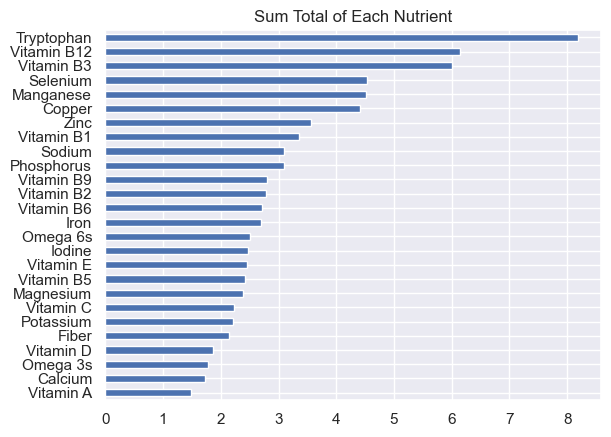

In [23]:
micro_nutrient_freq_sorted.plot.barh(title = 'Sum Total of Each Nutrient')

#### Analysis: 
This suggests that there is more tryptophan than any other nutrient in all foods. This is a measure that is fairly dependent on the data set and isn't as insightful as it may seem.  

<Axes: title={'center': 'Overall Average Concentration of Each Nutrient'}>

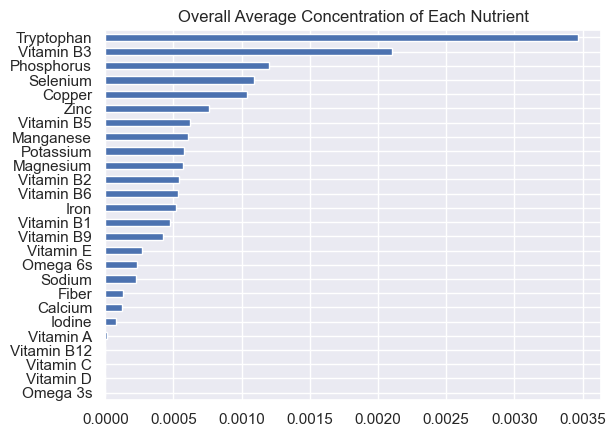

In [24]:
# Find median values of all nutrients
micro_nutrient_median = micro_matrix_portions.median(axis=1)
micro_nutrient_median_sorted = micro_nutrient_median.sort_values()
micro_nutrient_median_sorted.plot.barh(title = 'Overall Average Concentration of Each Nutrient')

<Axes: title={'center': 'Number of Foods with Each Nutrient'}>

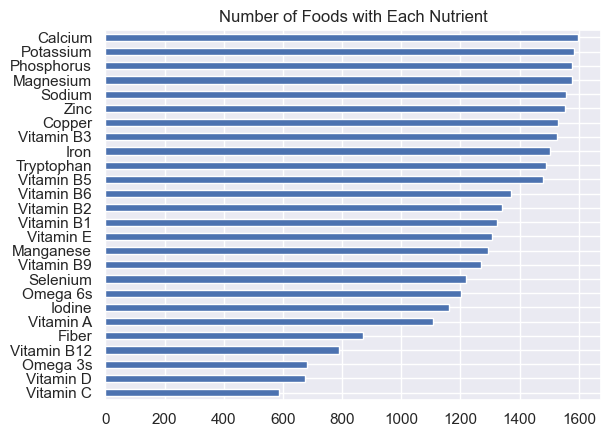

In [25]:
# Find rarest nutrients by number of non-zeros
micro_nutrient_nonzero = pd.Series(data = np.count_nonzero(micro_matrix_portions, axis=1), index=micro_matrix_portions.index)
micro_nutrient_nonzero_sorted = micro_nutrient_nonzero.sort_values()
micro_nutrient_nonzero_sorted.plot.barh(title = 'Number of Foods with Each Nutrient')

<Axes: title={'center': 'Percent of Foods with Each Nutrient'}>

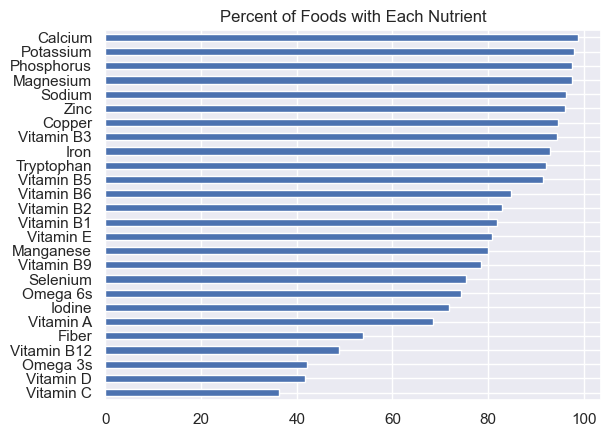

In [26]:
# Find rarest nutrients by percent of foods with each nutrient
micro_nutrient_percent = pd.Series(data = np.count_nonzero(micro_matrix_portions, axis=1)/micro_matrix_portions.shape[1]*100, 
                                   index=micro_matrix_portions.index)
micro_nutrient_percent_sorted = micro_nutrient_percent.sort_values()
micro_nutrient_percent_sorted.plot.barh(title = 'Percent of Foods with Each Nutrient')

#### Analysis:
This is a pretty stunning revelation! This suggests that the majority of foods in this data set have any given nutrient. However, there are still a few relatively rare nutrients. Namely, vitamin B12, omega 3s, and vitamins D & C. 

This begs the question, when these foods are present, are they in a higher concentration? If so, the problem of not having enough sources of these nutrients gets compensated by the higher dose of these nutrients in the sources that do contain them.

<Axes: title={'center': 'Average Concentration of Each Nutrient, When Present'}>

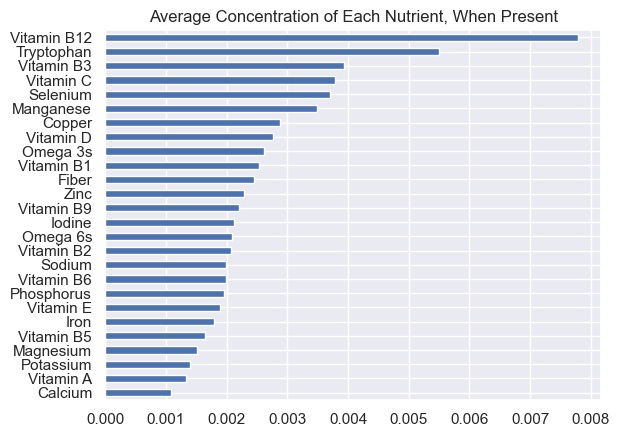

In [27]:
# Find average nutrient portion when present
micro_nutrient_nonzero_mean = micro_matrix_portions.apply(lambda row: row[row != 0].mean(), axis=1)
micro_nutrient_nonzero_mean_sorted = micro_nutrient_nonzero_mean.sort_values()
micro_nutrient_nonzero_mean_sorted.plot.barh(title = 'Average Concentration of Each Nutrient, When Present')

#### Analysis:

This does seem to be the case. The nutrients that appear less frequently have a higher concentration when they do appear. This makes sense in the case of vitamin B12. Only meat sources contain sufficient B12, but in meat sources it is dense.

So to get all these nutrients, how much variety do I need? 

<Axes: title={'center': 'Number of Unique Micro Nutrients in a Food'}, ylabel='Frequency'>

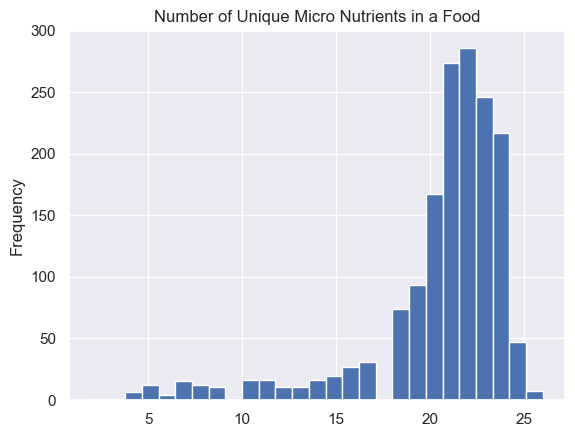

In [28]:
# Find how many nutrients does each food have
micro_per_food = pd.Series(data = np.count_nonzero(micro_matrix_portions, axis=0), index=micro_matrix_portions.columns)
micro_per_food_sorted = micro_per_food.sort_values()
micro_per_food.plot.hist(bins=27, title = 'Number of Unique Micro Nutrients in a Food')

In [29]:
micro_per_food_median = micro_per_food.median()
print(f'The average food has {int(micro_per_food_median)} out of {micro_matrix_portions.shape[0]} micro nutrients present')

The average food has 21 out of 26 micro nutrients present


#### Analysis
It is evident that it is easy to get a wide variety of nutrients with very few foods. After all, foods have 21/26 required micro nutrients on average. We can conclude from this that with moderate variety of food we can easily satisfy our daily needs. Using this revelation, we can prioritize calorie content to remain a healthy weight. Also, because we know that protein tends to increase feelings of satiety, we can prioritize foods with higher protein content.

Let's look at food density scaled by calories.

In [30]:
# Scale density score by calories

calories = nutrient_reduced['Calories']
calories = calories.rename(index=food_name) 

# Dropping 0 cal 'foods' like salt, baking powder, etc.
food_score_with_cal = pd.concat([micro_food_score, calories], axis=1)
food_score_with_cal = food_score_with_cal.rename(columns={0:'Score'})
zero_cal = calories[calories<0.005]
food_score_with_cal = food_score_with_cal.drop(index=zero_cal.index)

# Scale food score
food_score_scaled = food_score_with_cal['Score']/food_score_with_cal['Calories']
# micro_food_score_scaled_sorted = micro_food_score.sort_values()
# micro_food_score_scaled_sorted
food_score_scaled_sorted = food_score_scaled.sort_values(ascending=False)
print("Most nutrient dense foods:")
food_score_scaled_sorted.tail(20)

Most nutrient dense foods:


Flour, cornflour, from maize & wheat starch                                                            0.003584
Jelly crystals, sugar sweetened, all flavours                                                           0.00349
Soft drink, cola flavour, decaffeinated                                                                0.003136
Soft drink, cola flavour                                                                               0.003136
Lolly, hard varieties                                                                                  0.003108
Ice confection, stick, water-based, various flavours                                                   0.002975
Cream, imitation (non-dairy)                                                                           0.002774
Glucose, liquid or syrup                                                                               0.002718
Lolly, mint flavoured, sugar sweetened                                                                 0

#### Analysis:

We can see that this list hasn't changed considerably. Some things like coffee, tea, and spinach jumped up the list due to their low calorie count and decent nutrient content.

In [31]:
print("Least nutrient dense foods:")
food_score_scaled_sorted.tail(20)

Least nutrient dense foods:


Flour, cornflour, from maize & wheat starch                                                            0.003584
Jelly crystals, sugar sweetened, all flavours                                                           0.00349
Soft drink, cola flavour, decaffeinated                                                                0.003136
Soft drink, cola flavour                                                                               0.003136
Lolly, hard varieties                                                                                  0.003108
Ice confection, stick, water-based, various flavours                                                   0.002975
Cream, imitation (non-dairy)                                                                           0.002774
Glucose, liquid or syrup                                                                               0.002718
Lolly, mint flavoured, sugar sweetened                                                                 0

#### Analysis:

This list is not all that surprising. Alcohol, pure sugar, and soft drinks are the least nutritious foods you can eat. They tend to provide only calories with no micro nutrients. Oil would likely also be on this list if omega 3s were not included due to the fact that they are mostly pure calories.

It should also be noted that corn flour also makes the list. This is likely a form of pure starch and has little to no nutritional value besides that.

### Correlating nutrients with macros

In order to investigate which food types have higher nutrient density, I will try to correlate nutrient score(density) with macro nutrients. This will help guide food choice further.

In [32]:
# Make macro nutrient df that contains micro nutrient score#

macros = ['Calories', 'Carbs', 'Protein', 'Fat', 'Sugar', 'Saturated Fat'] # Not dropping omega fatty acids
dv = dv_clean['DV and RDI, Highest'] 
macros_with_micro_score = nutrient_reduced.drop(columns = nutrient_reduced.columns.difference(['Calories', 'Carbs', 'Protein', 
                                                                                               'Fat', 'Sugar', 'Saturated Fat']))
macros_with_micro_score = macros_with_micro_score.rename(index=food_name) # Put food names back in
macros_with_micro_score['Micro Score'] = micro_food_score
macros_with_micro_score.head()

,Calories,Protein,Fat,Sugar,Carbs,Saturated Fat,Micro Score
"Cardamom seed, dried, ground",2.942857,0.108,0.067,0.044,0.344,0.0220,0.297019
"Chilli (chili), dried, ground",3.047619,0.134,0.143,0.072,0.149,0.0206,0.539566
"Cinnamon, dried, ground",2.390476,0.040,0.012,0.022,0.275,0.0062,0.169504
"Cloves, dried, ground",3.307143,0.060,0.130,0.024,0.316,0.0549,0.318467
"Coriander seed, dried, ground",3.200000,0.124,0.178,0.024,0.084,0.0103,0.384677


In [33]:
# Make correlation matrix for macros and nutrient score
macros_with_micro_score.corr().style.background_gradient(cmap='coolwarm')

,Calories,Protein,Fat,Sugar,Carbs,Saturated Fat,Micro Score
Calories,1.000000,0.119396,0.844911,0.198656,0.391327,0.678888,0.218605
Protein,0.119396,1.000000,0.021909,-0.299097,-0.300995,0.018127,0.415735
Fat,0.844911,0.021909,1.000000,-0.039121,-0.082176,0.791120,0.127468
Sugar,0.198656,-0.299097,-0.039121,1.000000,0.609591,0.033901,-0.137656
Carbs,0.391327,-0.300995,-0.082176,0.609591,1.000000,-0.037064,-0.041255
Saturated Fat,0.678888,0.018127,0.791120,0.033901,-0.037064,1.000000,0.024261
Micro Score,0.218605,0.415735,0.127468,-0.137656,-0.041255,0.024261,1.000000


#### Analysis:

The highest correlations in this matrix are fats and calories, followed by carbs and calories. It is no surprise that fat and calories so strongly correlate, fats have twice as many calories per gram (9) as carbs and proteins (4). Carbs having a higher number that protein suggests that carbs tend to be more densely concentrated that protein in foods.

Furthermore, the highest correlation with nutrition score is protein. This further bolsters the idea that a calorie-controlled, high-protein diet is optimal for nutrition. Fat also correlated with nutrients somewhat positively, possibly due to fat soluable vitamins or the presence of omega 3s in our data set.

The strongest negative correlations in this matrix is between sugar and protein. This suggests that protein sources tend not to have any sugar and vice-versa. Additionally, sugar and carbs tend to be inversely proportional to nutrition. This is likely because a lot of empty calories tend to come from high-carb junk food. I do not believe this to suggest that carbs contain no nutrition, but that foods with little nutrition tend to have more carbs. 

## Classifing foods by food groups using PCA

#### Start with classifing with micronutrients only

In [34]:
micro_nutrient_matrix = micro_nutrient.copy()
micro_nutrient_matrix = micro_nutrient_matrix.rename(index=food_name).drop(columns='Food Name')
micro_nutrient_matrix.head()

,Fiber,Calcium,Copper,Iodine,Iron,Magnesium,Manganese,Phosphorus,Potassium,Selenium,...,Vitamin B5,Vitamin B6,Vitamin B12,Vitamin B9,Vitamin C,Vitamin D,Vitamin E,Omega 3s,Tryptophan,Omega 6s
"Cardamom seed, dried, ground",0.280,3.83,0.009413,0.000,0.1397,2.29,0.029609,1.78,11.19,0.117,...,0.000739,0.0023,0.0,0.03,0.21,0.0,0.0285,0.000000,1.55,0.0139
"Chilli (chili), dried, ground",0.348,3.30,0.011270,0.023,0.1730,1.49,0.008368,3.00,19.50,0.204,...,0.009595,0.0209,0.0,0.28,0.01,0.0,0.3814,0.000000,0.69,0.0669
"Cinnamon, dried, ground",0.531,10.02,0.001467,0.001,0.0832,0.60,0.008294,0.64,4.31,0.031,...,0.002908,0.0016,0.0,0.06,0.04,0.0,0.0232,0.000000,0.49,0.0012
"Cloves, dried, ground",0.339,6.32,0.009800,0.507,0.1183,2.59,0.035769,1.04,10.20,0.072,...,-0.001576,0.0039,0.0,0.25,0.00,0.0,0.0882,0.002666,0.30,0.0476
"Coriander seed, dried, ground",0.419,7.09,0.012652,0.023,0.1632,3.30,0.042471,4.09,12.67,0.262,...,0.003307,0.0004,0.0,0.00,0.21,0.0,0.0091,0.000000,1.78,0.0182


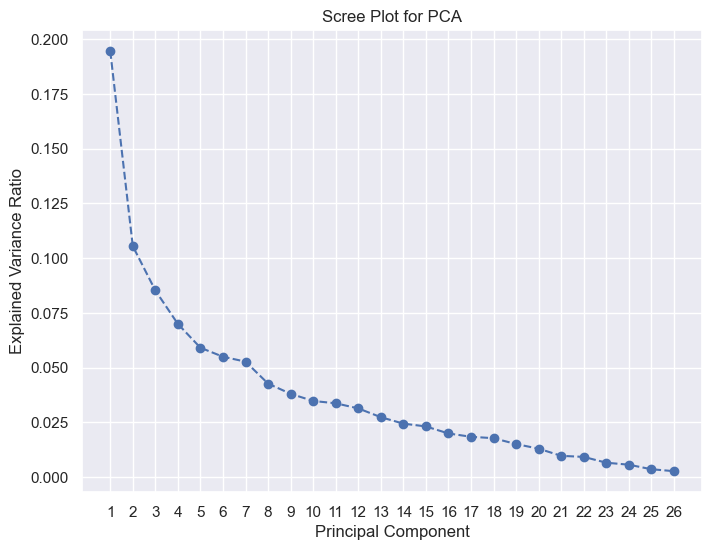

In [35]:
# Standardize the data
scaler = StandardScaler()
micro_nutrient_scaled = scaler.fit_transform(micro_nutrient_matrix)

pca = PCA()
pca.fit(micro_nutrient_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Generate the elbow curve (scree plot)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

Although it is a somewhat gradual plot, there is a noticable elbow at 5 PC's. This will be the number we use for our PCA

Original shape: (1616, 26)
Transformed shape: (1616, 5)


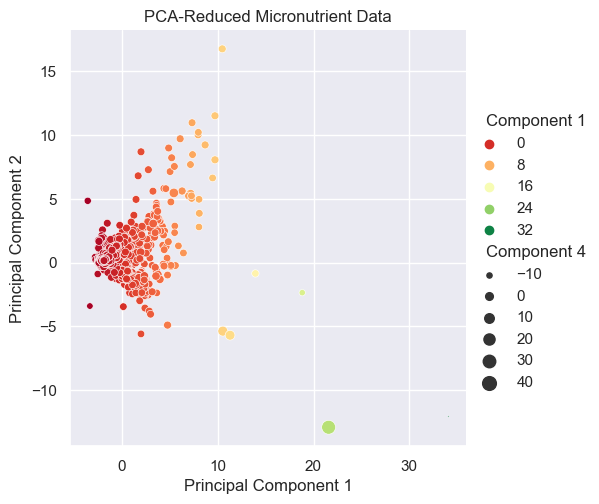

In [36]:
# Reduce the Data to principal components

# Standardize the data
scaler = StandardScaler()
micro_nutrient_scaled = scaler.fit_transform(micro_nutrient_matrix)

# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=5)
micro_nutrient_reduced = pca.fit_transform(micro_nutrient_scaled)

# Verify change
print("Original shape:", micro_nutrient_scaled.shape)
print("Transformed shape:", micro_nutrient_reduced.shape)

# Make df once more

micro_reduced_df = pd.DataFrame(micro_nutrient_reduced, columns = ['Component 1','Component 2','Component 3',
                                                                   'Component 4','Component 5'])
# Plot the transformed data
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

# print(micro_nutrient_reduced[:,0].shape, micro_nutrient_reduced[:,1].shape, micro_nutrient_reduced[:,2].shape)
sns.set_theme()
sns.relplot(data=micro_reduced_df, x='Component 1', y='Component 2',
            hue='Component 1', palette='RdYlGn',
            size = 'Component 4', sizes = (1,100)
           )


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Micronutrient Data')
plt.show()



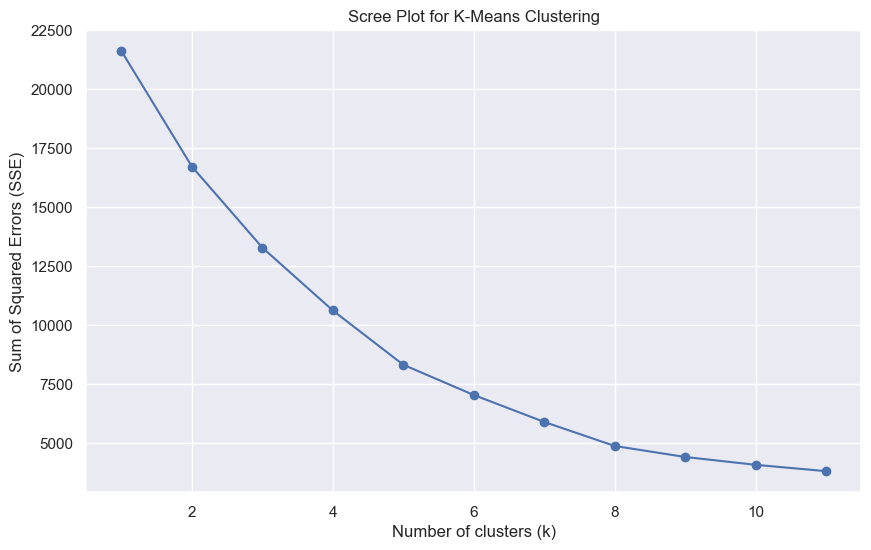

In [47]:
# Calculate SSE for different values of k

# Suppress FutureWarning
import warnings
warnings.filterwarnings("ignore")

sse = []
k_range = range(1, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(micro_nutrient_reduced)
    sse.append(kmeans.inertia_)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Scree Plot for K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

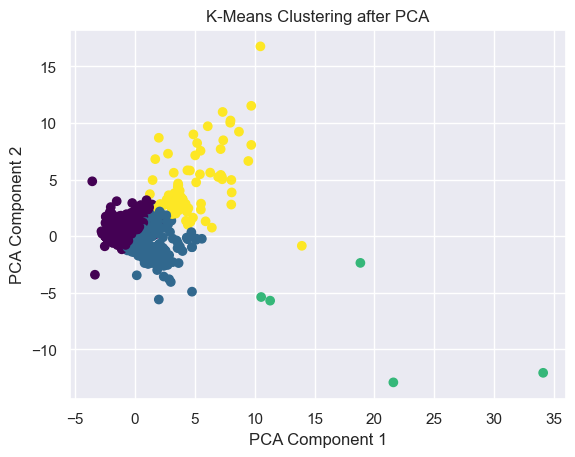

In [38]:
# Attempt K-means clustering

# Do clustering
n_clusters = 4  # Number of food subgroups
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(micro_nutrient_reduced)

# Plot first two components
plt.scatter(micro_nutrient_reduced[:,0], micro_nutrient_reduced[:,1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering after PCA')
plt.show()

In [49]:
# Put clusters back in
micro_nutrient_clusters = micro_nutrient_matrix.copy()
micro_nutrient_clusters['Cluster'] = clusters

# Find foods in different clusters
clustered_nutr = micro_nutrient_clusters.groupby('Cluster')

# Print different group contents
rand_samples = []
np.random.seed(10)
for n in range(0,n_clusters):
    sample = np.random.choice(np.asarray(clustered_nutr.get_group(n).index), 10) #take 10 random samples
    temp = []
    for s in sample:
        if s.split()[0][-1] == ',':
            temp.append(s.split()[0][:-1])
        else:
             temp.append(s.split()[0])
    rand_samples.append(temp)
    print(f'Number of foods in group {n+1}: {len(np.asarray(clustered_nutr.get_group(n).index))}')

table_header = ['Group 1','Group 2','Group 3','Group 4']
table = tabulate(np.asarray(rand_samples).transpose(), headers=table_header)
print(table)

Number of foods in group 1: 917
Number of foods in group 2: 603
Number of foods in group 3: 1
Number of foods in group 4: 95
Group 1       Group 2    Group 3    Group 4
------------  ---------  ---------  ---------
Flour         Cheese     Spread     Oregano
Bread         Beef       Spread     Bean
Passionfruit  Lamb       Spread     Tahini
Sausage       Spam       Spread     Lupin
Ice           Beef       Spread     Muesli
Bread         Bream      Spread     Nut
Bread         Turkey     Spread     Nut
Cabbage       Pork       Spread     Peanut
Grape         Mulloway   Spread     Milk
Spinach       Pork       Spread     Bean


#### Now include macronutrients with calories

In [40]:
# Make data structure of clustering
nutrient_matrix = nutrient_reduced.copy()
nutrient_matrix = nutrient_matrix.rename(index=food_name).drop(columns='Food Name')
drop_calories = True # toggle to drop calories column
if drop_calories:
    nutrient_matrix = nutrient_matrix.drop(columns='Calories')
nutrient_matrix.head()

,Protein,Fat,Fiber,Sugar,Carbs,Calcium,Copper,Iodine,Iron,Magnesium,...,Vitamin B12,Vitamin B9,Vitamin C,Vitamin D,Vitamin E,Saturated Fat,Omega 3s,Cholesterol,Tryptophan,Omega 6s
"Cardamom seed, dried, ground",0.108,0.067,0.280,0.044,0.344,3.83,0.009413,0.000,0.1397,2.29,...,0.0,0.03,0.21,0.0,0.0285,0.0220,0.000000,0.0,1.55,0.0139
"Chilli (chili), dried, ground",0.134,0.143,0.348,0.072,0.149,3.30,0.011270,0.023,0.1730,1.49,...,0.0,0.28,0.01,0.0,0.3814,0.0206,0.000000,0.0,0.69,0.0669
"Cinnamon, dried, ground",0.040,0.012,0.531,0.022,0.275,10.02,0.001467,0.001,0.0832,0.60,...,0.0,0.06,0.04,0.0,0.0232,0.0062,0.000000,0.0,0.49,0.0012
"Cloves, dried, ground",0.060,0.130,0.339,0.024,0.316,6.32,0.009800,0.507,0.1183,2.59,...,0.0,0.25,0.00,0.0,0.0882,0.0549,0.002666,0.0,0.30,0.0476
"Coriander seed, dried, ground",0.124,0.178,0.419,0.024,0.084,7.09,0.012652,0.023,0.1632,3.30,...,0.0,0.00,0.21,0.0,0.0091,0.0103,0.000000,0.0,1.78,0.0182


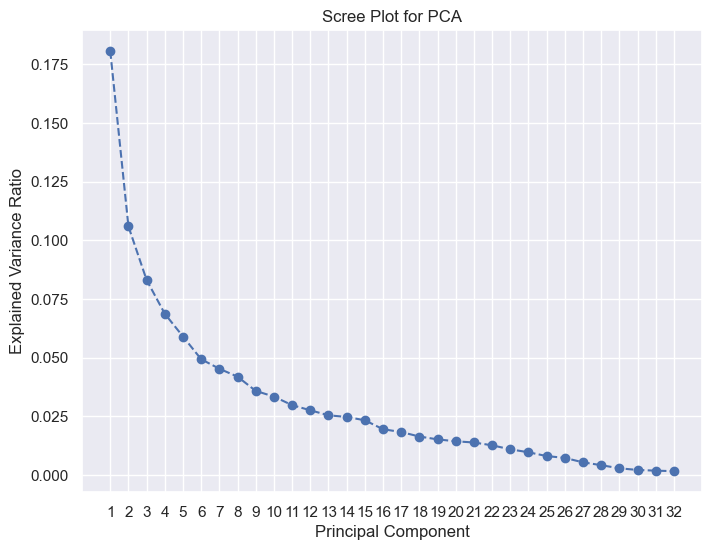

In [41]:
# Standardize the data
scaler = StandardScaler()
nutrient_scaled = scaler.fit_transform(nutrient_matrix)

pca = PCA()
pca.fit(nutrient_scaled)

# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Generate the elbow curve (scree plot)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot for PCA')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid(True)

Original shape: (1616, 32)
Transformed shape: (1616, 5)


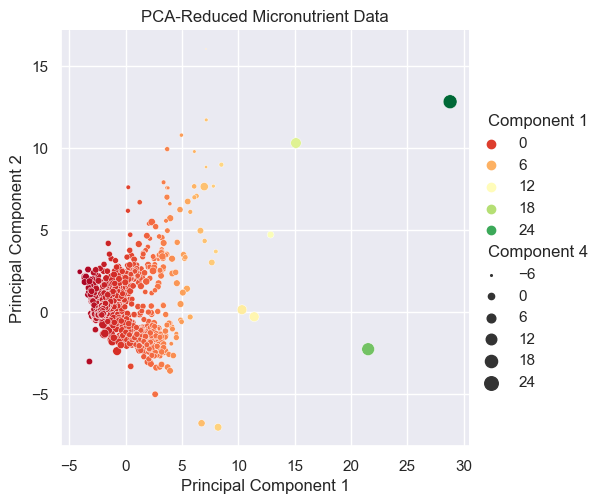

In [42]:
# Reduce the Data to principal components

# Standardize the data
scaler = StandardScaler()
nutrient_scaled = scaler.fit_transform(nutrient_matrix)

# Apply PCA to reduce to 3 dimensions
pca = PCA(n_components=5)
nutrient_reduced_matrix = pca.fit_transform(nutrient_scaled)

# Verify change
print("Original shape:", nutrient_scaled.shape)
print("Transformed shape:", nutrient_reduced_matrix.shape)

# Make df once more

nutrient_reduced_df = pd.DataFrame(nutrient_reduced_matrix, columns = ['Component 1','Component 2','Component 3',
                                                                   'Component 4','Component 5'])
# Plot the transformed data
# plt.scatter(X_reduced[:, 0], X_reduced[:, 1])

# print(micro_nutrient_reduced[:,0].shape, micro_nutrient_reduced[:,1].shape, micro_nutrient_reduced[:,2].shape)
sns.set_theme()
sns.relplot(data=nutrient_reduced_df, x='Component 1', y='Component 2',
            hue='Component 1', palette='RdYlGn',
            size = 'Component 4', sizes = (1,100)
           )


plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA-Reduced Micronutrient Data')
plt.show()


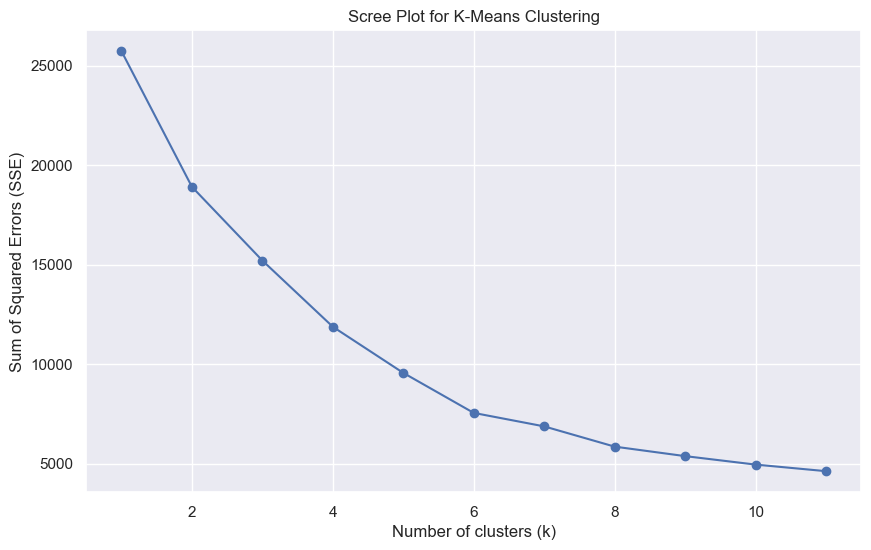

In [48]:
# Calculate SSE for different values of k

sse = []
k_range = range(1, 12)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(nutrient_reduced_matrix)
    sse.append(kmeans.inertia_)

# Plot the Scree Plot
plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Scree Plot for K-Means Clustering')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()

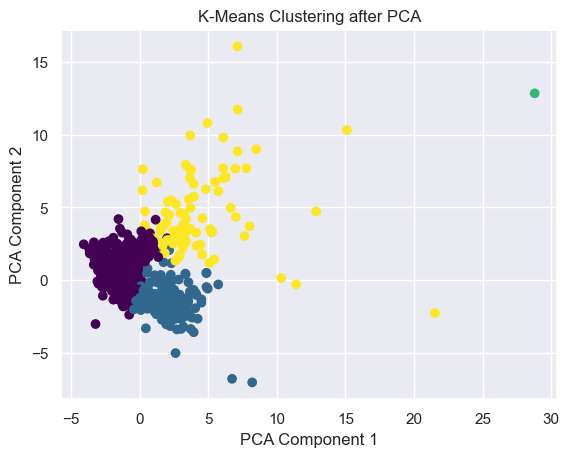

In [44]:
# Attempt K-means clustering
from sklearn.cluster import KMeans

# Do clustering
n_clusters = 4  # Number of food subgroups
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(nutrient_reduced_matrix)

# Plot first two components
plt.scatter(nutrient_reduced_matrix[:,0], nutrient_reduced_matrix[:,1], c=clusters, cmap='viridis')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering after PCA')
plt.show()

In [45]:
# Put clusters back in
micro_nutrient_clusters = micro_nutrient_matrix.copy()
micro_nutrient_clusters['Cluster'] = clusters

# Find foods in different clusters
clustered_nutr = micro_nutrient_clusters.groupby('Cluster')

# Print different group contents
rand_samples = []
np.random.seed(10)
for n in range(n_clusters):
    sample = np.random.choice(np.asarray(clustered_nutr.get_group(n).index), 10) #take 10 random samples
    temp = []
    for s in sample:
        if s.split()[0][-1] == ',':
            temp.append(s.split()[0][:-1])
        else:
             temp.append(s.split()[0])
    rand_samples.append(temp)
    print(f'Number of foods in group {n+1}: {len(np.asarray(clustered_nutr.get_group(n).index))}')

table_header = ['Group 1','Group 2','Group 3','Group 4']
table = tabulate(np.asarray(rand_samples).transpose(), headers=table_header)
print(table)


Number of foods in group 1: 917
Number of foods in group 2: 603
Number of foods in group 3: 1
Number of foods in group 4: 95
Group 1       Group 2    Group 3    Group 4
------------  ---------  ---------  ---------
Flour         Cheese     Spread     Oregano
Bread         Beef       Spread     Bean
Passionfruit  Lamb       Spread     Tahini
Sausage       Spam       Spread     Lupin
Ice           Beef       Spread     Muesli
Bread         Bream      Spread     Nut
Bread         Turkey     Spread     Nut
Cabbage       Pork       Spread     Peanut
Grape         Mulloway   Spread     Milk
Spinach       Pork       Spread     Bean
